In [158]:
import json

import nltk
from nltk.corpus import wordnet

import random
import re
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, create_optimizer
from transformers import T5ForConditionalGeneration, T5Tokenizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [159]:

# Load the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-base')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

def paraphrase(sentence, num_return_sequences=5, num_beams=5):
    # Preprocess the input sentence
    text = "paraphrase: " + sentence + " </s>"
    encoding = tokenizer.encode_plus(text, max_length=512, padding='max_length', return_tensors="pt")
    
    # Generate paraphrases
    input_ids, attention_mask = encoding["input_ids"], encoding["attention_mask"]
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_mask,
        max_length=512,
        num_beams=num_beams,
        num_return_sequences=num_return_sequences,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True
    )
    
    # Decode and return the paraphrased sentences
    paraphrases = [tokenizer.decode(output, skip_special_tokens=True, clean_up_tokenization_spaces=True) for output in outputs]
    return paraphrases

# Example usage
original_sentence = "The restaurant's aesthetic, too, has grown with time, now an Instagram-worthy ambiance from every corner."
paraphrased_sentences = paraphrase(original_sentence, num_return_sequences=5)

for i, sentence in enumerate(paraphrased_sentences):
    print(f"Paraphrase {i+1}: {sentence}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Paraphrase 1: True
Paraphrase 2: positive
Paraphrase 3: negative
Paraphrase 4: Falsch
Paraphrase 5: Falses


In [160]:
# Step 1: Load the JSON file
with open('/Users/pablonieuwenhuys/EatzAI/latest.json', 'r') as f:
    data = json.load(f)

In [161]:

augmented_sentences = []
augmented_labels = []

for item in data:
    text = item.get('data', {}).get('text', "")
    annotations = item.get('annotations', [])
    if annotations and 'result' in annotations[0]:
        results = annotations[0]['result']
        if results and 'value' in results[0] and 'choices' in results[0]['value']:
            sentence_labels = results[0]['value']['choices']
        else:
            sentence_labels = []
    else:
        sentence_labels = []

    # Assuming 'Ambiance' and 'Service' are underrepresented
    if 'ambiance' in sentence_labels or 'service' in sentence_labels:
        # Generate paraphrases
        paraphrased_sentences = paraphrase(text, num_return_sequences=5)
        for paraphrased_sentence in paraphrased_sentences:
            augmented_sentences.append(paraphrased_sentence)
            augmented_labels.append(sentence_labels)

# Combine original and augmented data
for item in data:
    text = item.get('data', {}).get('text', "")
    annotations = item.get('annotations', [])
    if annotations and 'result' in annotations[0]:
        results = annotations[0]['result']
        if results and 'value' in results[0] and 'choices' in results[0]['value']:
            sentence_labels = results[0]['value']['choices']
        else:
            sentence_labels = []
    else:
        sentence_labels = []

    augmented_sentences.append(text)
    augmented_labels.append(sentence_labels)

# Check the number of sentences generated
num_sentences = len(augmented_sentences)
print(f"Total number of sentences generated (including original and augmented): {num_sentences}")


Total number of sentences generated (including original and augmented): 2356


In [162]:
# Step 3: Preprocess Text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

nltk.download('punkt')
sentences = [preprocess_text(sentence) for sentence in augmented_sentences]
labels = augmented_labels

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pablonieuwenhuys/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [163]:
# Step 4: Encode Labels
mlb = MultiLabelBinarizer()
labels_encoded = mlb.fit_transform(labels)

In [164]:
# Step 5: Tokenize Sentences using DistilBERT Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encodings = tokenizer(sentences, truncation=True, padding=True)

input_ids = encodings['input_ids']
attention_masks = encodings['attention_mask']

In [165]:
# Step 6: Split the Data into Training and Validation Sets
train_input_ids, val_input_ids, train_attention_masks, val_attention_masks, train_labels, val_labels = train_test_split(
    input_ids, attention_masks, labels_encoded, test_size=0.2, random_state=0
)

# Convert input_ids and attention_masks to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_input_ids,
        'attention_mask': train_attention_masks
    },
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': val_input_ids,
        'attention_mask': val_attention_masks
    },
    val_labels
))


In [166]:
# Step 7: Define and Compile the Model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=labels_encoded.shape[1])

for layer in model.layers[:-2]:
    layer.trainable = False

num_train_steps = len(train_dataset) * 7  # Assuming 7 epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=3e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=100
)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [167]:
#tf.config.run_functions_eagerly(True)

In [168]:
# Step 8: Train the Model
history = model.fit(
    train_dataset.batch(8),
    epochs=5,
    validation_data=val_dataset.batch(16),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)

Epoch 1/5
236/236 [==============================] - 64s 265ms/step - loss: 0.6607 - accuracy: 0.3880 - val_loss: 0.6334 - val_accuracy: 0.3771
Epoch 2/5
236/236 [==============================] - 64s 271ms/step - loss: 0.6105 - accuracy: 0.4087 - val_loss: 0.5973 - val_accuracy: 0.3771
Epoch 3/5
236/236 [==============================] - 66s 279ms/step - loss: 0.5808 - accuracy: 0.4087 - val_loss: 0.5770 - val_accuracy: 0.3771
Epoch 4/5
236/236 [==============================] - 76s 323ms/step - loss: 0.5636 - accuracy: 0.4087 - val_loss: 0.5653 - val_accuracy: 0.3771
Epoch 5/5
236/236 [==============================] - 73s 307ms/step - loss: 0.5532 - accuracy: 0.4087 - val_loss: 0.5580 - val_accuracy: 0.3771


In [169]:
# Step 9: Evaluate the Model
val_predictions = model.predict(val_dataset.batch(16))
val_probs = tf.nn.sigmoid(val_predictions.logits)
val_preds = (val_probs > 0.5).numpy()  # Adjust threshold as needed

# Print evaluation metrics (e.g., precision, recall, F1-score)
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("Classification Report:")
print(classification_report(val_labels, val_preds, target_names=mlb.classes_, zero_division=0))

precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
recall = recall_score(val_labels, val_preds, average='micro', zero_division=0)
f1 = f1_score(val_labels, val_preds, average='micro', zero_division=0)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

30/30 [==============================] - 3s 103ms/step
Classification Report:
              precision    recall  f1-score   support

    ambiance       0.00      0.00      0.00       132
        food       0.00      0.00      0.00       161
        none       0.00      0.00      0.00        38
     service       0.53      1.00      0.69       250

   micro avg       0.53      0.43      0.48       581
   macro avg       0.13      0.25      0.17       581
weighted avg       0.23      0.43      0.30       581
 samples avg       0.53      0.45      0.48       581

Precision: 0.5308
Recall: 0.4303
F1-Score: 0.4753


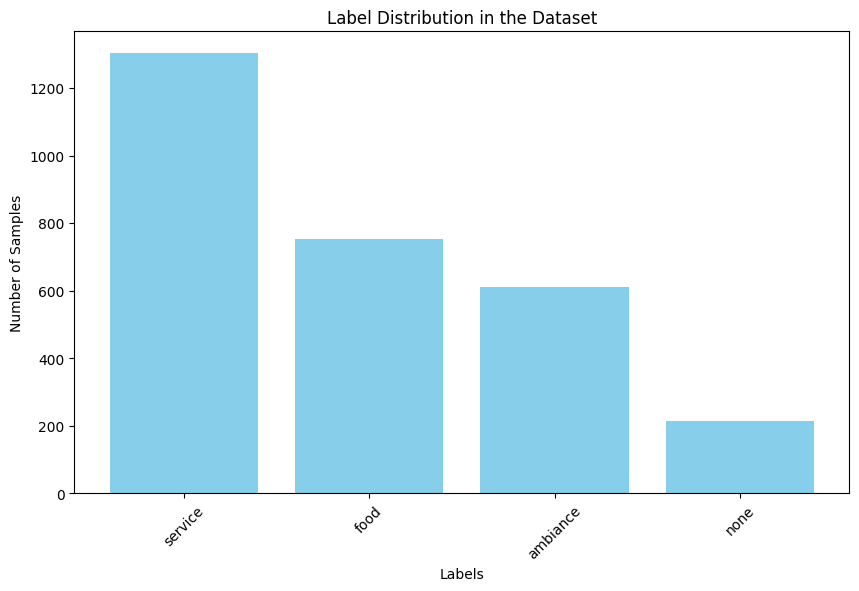

3    1302
1     752
0     612
2     213
Name: Count, dtype: int64 3     service
1        food
0    ambiance
2        none
Name: Label, dtype: object


In [170]:

# Assuming labels_encoded is a numpy array with shape (num_samples, num_labels)
# and mlb is your MultiLabelBinarizer instance with the class names

# Sum over the samples (axis=0) to count the number of occurrences for each label
label_counts = np.sum(labels_encoded, axis=0)

# Convert to a pandas DataFrame for easier plotting
label_counts_df = pd.DataFrame({
    'Label': mlb.classes_,
    'Count': label_counts
})

# Sort the DataFrame by count for better visualization
label_counts_df = label_counts_df.sort_values('Count', ascending=False)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(label_counts_df['Label'], label_counts_df['Count'], color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Label Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()
print(label_counts_df['Count'], label_counts_df['Label'])


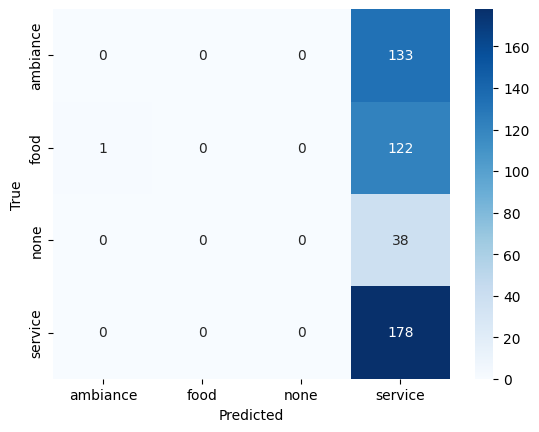

In [171]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(np.argmax(val_labels, axis=1), np.argmax(val_preds, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
